In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.1.0'

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

In [5]:
import numpy as np
import pandas as pd
from itertools import product
from string import ascii_uppercase
import matplotlib.pyplot as plt
from typing import Union

## 1. RNN without noise

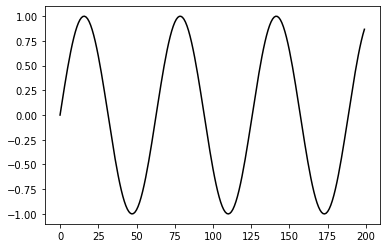

In [6]:
series: np.ndarray = np.sin(0.1 * np.arange(200))

plt.plot(series, c='k')
plt.show()

### Create the sythetic dataset

We create rolling windows of 10 periods. As we have a time series of 200 observations, we end up with 190 since we loose 10.

In [7]:
T: int = 10
D: int = 1
X_li: list = []
Y_li: list = []

for t in range(len(series) - T):
    x: np.ndarray = series[t:t + T]
    X_li.append(x)
    y: np.ndarray = series[t + T]
    Y_li.append(y)

X: np.ndarray = np.array(X_li).reshape(-1, T, 1)  # (N, T, D)
Y: np.ndarray = np.array(Y_li)
N: int = len(X)
    
print(f"X.shape: {X.shape}, Y.shape: {Y.shape}")

X.shape: (190, 10, 1), Y.shape: (190,)


### Build the RNN model

In [8]:
inp = Input(shape=(T, 1))
x = SimpleRNN(units=5)(inp)
x = Dense(1)(x)
model = Model(inp, x)

In [9]:
model.compile(optimizer=Adam(learning_rate=0.1), loss='mse')

### Training the RNN

When we do our train test split we don't want to randomly pick samples across the entire time period for the validation set. The pupose of forecasting is to predict the future and, thus, when we split up our data, our validation set should always be future data points and the train set should only contain data points before that.

In [10]:
r = model.fit(X[:-N//2], Y[:-N//2], epochs=80, validation_data=(X[-N//2:], Y[-N//2:]))

Train on 95 samples, validate on 95 samples
Epoch 1/80
95/95 [==============================] - 1s 11ms/sample - loss: 0.4699 - val_loss: 0.1695
Epoch 2/80
95/95 [==============================] - 0s 294us/sample - loss: 0.1914 - val_loss: 0.1293
Epoch 3/80
95/95 [==============================] - 0s 326us/sample - loss: 0.0974 - val_loss: 0.0831
Epoch 4/80
95/95 [==============================] - 0s 325us/sample - loss: 0.0444 - val_loss: 0.0141
Epoch 5/80
95/95 [==============================] - 0s 336us/sample - loss: 0.0224 - val_loss: 0.0624
Epoch 6/80
95/95 [==============================] - 0s 315us/sample - loss: 0.0441 - val_loss: 0.0292
Epoch 7/80
95/95 [==============================] - 0s 315us/sample - loss: 0.0168 - val_loss: 0.0101
Epoch 8/80
95/95 [==============================] - 0s 305us/sample - loss: 0.0126 - val_loss: 0.0114
Epoch 9/80
95/95 [==============================] - 0s 325us/sample - loss: 0.0118 - val_loss: 0.0177
Epoch 10/80
95/95 [====================

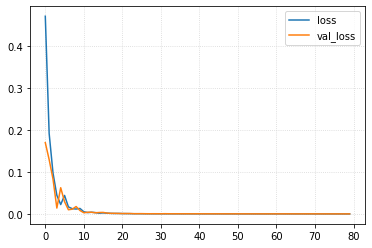

In [11]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.grid(c='lightgray', ls=':')
plt.show()

### One-step (wrong!) forecast

In [12]:
validation_target = Y[-N//2:]
validation_predictions = []

i: int = -N//2

while len(validation_predictions) < len(validation_target):
    p = model.predict(X[i].reshape(1, -1, 1))[0, 0]  # Scalar    
    validation_predictions.append(p)
    i += 1

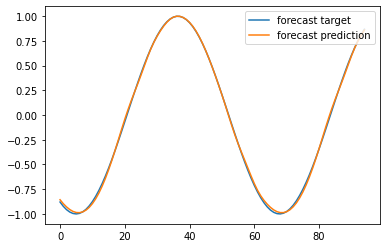

In [13]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()
plt.show()

As expected, this looks very nice. But this forecast can be misleading as we incorporate future information.

### Multiple-step (right) forecast

In [14]:
validation_target = Y[-N//2:]
validation_predictions = []

last_x: int = X[-N//2]  # (1, T)

while len(validation_predictions) < len(validation_target):
    p = model.predict(last_x.reshape(1, -1, 1))[0, 0]  # Scalar
    validation_predictions.append(p)
    
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

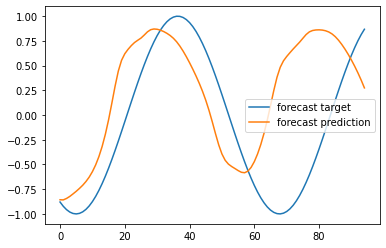

In [15]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()
plt.show()

So, here we can see that our RNN with the default parameters does not perform as we as a linear regression that captures better the underlying cyclical behaviour. This is a very intriguing result. The autoregressive linear model does predict perfectly. In fact, we proved that we could find the coefficients of an AR(2) model analytically. 

So, why does an RNN not perform as well as the AR(2)? The answer is that an RNN has too much flexibility.

In [49]:
class SineModel:
    def __init__(self, noise: bool = True, activation: Union[str, None] = None, T: int = 10):
        self.series: np.ndarray = np.sin(0.1 * np.arange(200)) + np.random.randn(200) * 0.1 if noise else np.sin(0.1 * np.arange(200))
        self.activation: Union[str, NoneType] = activation
        self.T: int = 10
        self.X, self.Y, self.N = self.__generate_dataset()
        self.history = None
        self.validation_target = None
        self.validation_predictions = None
        self.model = None
    
    def __generate_dataset(self) -> tuple:
        T: int = self.T
        D: int = 1
        X_: list = []
        Y_: list = []

        for t in range(len(self.series) - T):
            x: np.ndarray = self.series[t:t + T]
            X_.append(x)
            y: np.ndarray = self.series[t + T]
            Y_.append(y)

        X: np.ndarray = np.array(X_).reshape(-1, T, 1)  # (N, T, D)
        Y: np.ndarray = np.array(Y_)
        N: int = len(X)
        return X, Y, N
    
    def build_simple_rnn(self, verbose: bool = True):
        inp = Input(shape=(T, 1))
        x = SimpleRNN(units=5, activation=self.activation)(inp)
        x = Dense(1)(x)
        model = Model(inp, x)
        model.compile(optimizer=Adam(learning_rate=0.1), loss='mse')
        r = model.fit(X[:-N//2], Y[:-N//2], epochs=80, validation_data=(X[-N//2:], Y[-N//2:]), verbose=verbose)
        self.model = model
        return r
    
    def plot_loss(self, verbose: bool):
        r = self.history
        if r is None:
            r = self.build_simple_rnn(verbose)
        plt.plot(r.history['loss'], label='loss')
        plt.plot(r.history['val_loss'], label='val_loss')
        plt.legend()
        plt.grid(c='lightgray', ls=':')
        plt.show()
    
    def compute_validation_predictions(self, is_wrong: bool = False) -> list:
        if self.model is not None:
            validation_target = self.Y[-self.N//2:]
            validation_predictions = []

            if is_wrong:
                print("WRONG look-ahead bias in forecasting")
                i: int = -N//2

                while len(validation_predictions) < len(validation_target):
                    p = self.model.predict(self.X[i].reshape(1, -1, 1))[0, 0]  # Scalar    
                    validation_predictions.append(p)
                    i += 1
            else:
                print("RIGHT")
                last_x: int = X[-N//2]  # (1, T)

                while len(validation_predictions) < len(validation_target):
                    p = self.model.predict(last_x.reshape(1, -1, 1))[0, 0]  # Scalar
                    validation_predictions.append(p)

                    last_x = np.roll(last_x, -1)
                    last_x[-1] = p

            self.validation_target = validation_target
            self.validation_predictions = validation_predictions
        else:
            print("You have to build a model first.")
    
    def plot_target_vs_prediction(self):
        if (self.validation_predictions and self.validation_target) is not None:
            plt.plot(self.validation_target, label='forecast target')
            plt.plot(self.validation_predictions, label='forecast prediction')
            plt.legend()
            plt.show()
        else:
            print("First run 'compute_validation_predictions()' method.")

In [17]:
args = {'noise': (True, False), 'activation': ('tanh', 'relu', None), 'is_wrong': (True, False)}

In [51]:
def plot_combinations():
    comb = tuple(product(args['noise'], args['is_wrong']))
    # ((True, True), (True, False), (False, True), (False, False))
    f = plt.figure(figsize=(10, 35))
    it = iter(range(12))
    alpha = iter(ascii_uppercase)

    for i, fn in enumerate(('tanh', 'relu', None)):
        for tup in comb:
            n = next(it)
            print(f"Computing model {n + 1}/12")
            m = SineModel(noise=tup[0], activation=fn)
            m.build_simple_rnn(verbose=False)
            m.compute_validation_predictions(is_wrong=tup[1])

            ax = f.add_subplot(12, 2, n + 1)
            ax.set_title(f"({next(alpha)}) (noise={tup[0]}, fn={fn}, is wrong? {tup[1]})")
            ax.plot(m.validation_target, label='forecast target')
            ax.plot(m.validation_predictions, label='forecast prediction')
            ax.legend()
    
    plt.tight_layout()
    plt.show()

Computing model 1/12
is wrong
Computing model 2/12
is true
Computing model 3/12
is wrong
Computing model 4/12
is true
Computing model 5/12
is wrong
Computing model 6/12
is true
Computing model 7/12
is wrong
Computing model 8/12
is true
Computing model 9/12
is wrong
Computing model 10/12
is true
Computing model 11/12
is wrong
Computing model 12/12
is true


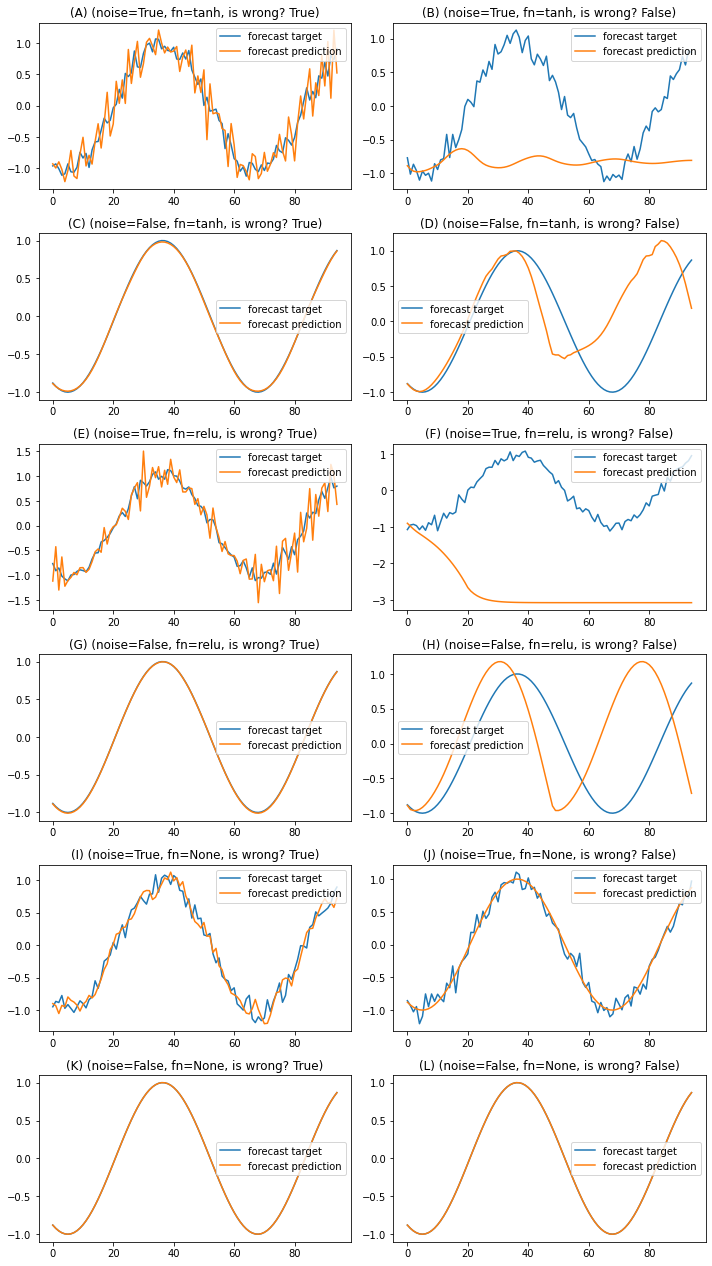

In [52]:
plot_combinations()

A neural network with **no** activation functions just reduces to a **linear model**. This is what we see in plots where the activation function is `None`. We know that a linear model is perfect for our generated dataset. Therefore, they will outperform RNNs with other activation functions. Thus, as expected, plot (I) seems to be very close to the the series because of the look-ahead bias (i.e., future information is incorporated in the forecast when it should not be known). We can also observe that the model in plot (J) understands almost perfectly the underlying sine cyclical behavior. As the activation function is None, we are dealing with a linear regression with a close-form solution.

For the noisy version using $\tanh$ activation function, the consequence of doing wrong versus right forecasting is dramatic. Not only if bias is introduced investors would be expecting high returns, but the out-of-sample result would have been so bad, that they would have loosed a huge quantity of their investments. This is what plots (A) and (B) tell us. In (B) we also notice that RNN does perform very bad at this task. It might be the case that the RNN would perform well -- even better than the linear model -- but this result is not consistent. This suggests that more tuning is required.

With the ReLU activation, the same story as for $\tanh$ holds. Moreover, in (F) the model is not a model at all. It is just taking the last value and propagating to the new prediction.

is wrong


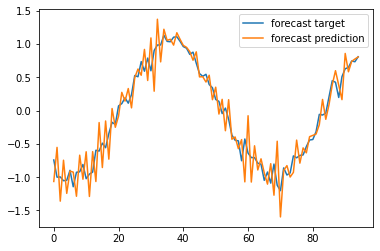

In [50]:
m = SineModel(noise=True, activation=None)
m.build_simple_rnn(verbose=False)
m.compute_validation_predictions(is_wrong=True)
m.plot_target_vs_prediction()